## Low Pass and High Pass Filtering Code

Includes preprocessing code before the filtering. I am assuming the dimensions of the input are:

Examples x Channels (1) x Electrodes (22) x Time

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch import Tensor
from typing import Type
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random
from scipy.signal import butter, filtfilt

cudnn.benchmark = True
plt.ion()   # interactive mode

if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


Functions from preprocessing

In [2]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y

def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

In [3]:
# Load training data
X_train_valid = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/X_train_valid.npy")
y_train_valid = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/y_train_valid.npy")
y_train_valid = y_train_valid - 769
person_train_valid = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/person_train_valid.npy")

# Load test data
X_test = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/X_test.npy")
y_test = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/y_test.npy")
y_test = y_test - 769
person_test = np.load("C:/Users/awong/OneDrive/Desktop/PythonScripts/C147HW/Final Project/project_data/project/person_test.npy")

# Print shapes
print('X train: ', X_train_valid.shape)
print('y train: ', y_train_valid.shape)
print('Person train+valid: ', person_train_valid.shape)
print('X test: ', X_test.shape)
print('y test: ', y_test.shape)
print('Person test: ', person_test.shape)

X train:  (2115, 22, 1000)
y train:  (2115,)
Person train+valid:  (2115, 1)
X test:  (443, 22, 1000)
y test:  (443,)
Person test:  (443, 1)


In [4]:
## Randomly split the train/validation dataset
ind_valid = np.random.choice(X_train_valid.shape[0], int(X_train_valid.shape[0]/5), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
x_valid, y_valid = X_train_valid[ind_valid], y_train_valid[ind_valid]
x_train, y_train = X_train_valid[ind_train], y_train_valid[ind_train]
print('Training and Validation shapes before preprocessing: ')
print('X train: ', x_train.shape, ' Y train: ', y_train.shape)
print('X val: ', x_valid.shape, ' Y val', y_valid.shape)

# Preprocessing the dataset
# pass only training data to train prep, val and test data to test prep

x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_test, x_valid = test_data_prep(X_test), test_data_prep(x_valid) 

x_train = torch.tensor(x_train).detach().float().to(device)
x_valid = torch.tensor(x_valid).detach().float().to(device)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train, y_valid, y_test = torch.tensor(y_train).to(device), torch.tensor(y_valid).to(device), torch.tensor(y_test).to(device)
y_train = nn.functional.one_hot(y_train.long(), 4)
y_valid = nn.functional.one_hot(y_valid.long(), 4)
y_test = nn.functional.one_hot(y_test.long(), 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 2,3)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 2,3)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 2,3)
x_test = torch.tensor(x_test).detach().float().to(device)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Training and Validation shapes before preprocessing: 
X train:  (1692, 22, 1000)  Y train:  (1692,)
X val:  (423, 22, 1000)  Y val (423,)
Shape of X after trimming: (1692, 22, 800)
Shape of X after maxpooling: (1692, 22, 400)
Shape of X after averaging+noise and concatenating: (3384, 22, 400)
Shape of X after subsampling and concatenating: (6768, 22, 400)
Shape of Y: (6768,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (423, 22, 800)
Shape of X after maxpooling: (423, 22, 400)
Shape of training set: torch.Size([6768, 22, 400])
Shape of validation set: torch.Size([423, 22, 400])
Shape of training labels: (6768,)
Shape of validation labels: (423,)
Shape of training labels after categorical conversion: torch.Size([6768, 4])
Shape of validation labels after categorical conversion: torch.Size([423, 4])
Shape of test labels after categorical conversion: torch.Size([443, 4])
Shape of training set after adding width info: torc

In [5]:
# Convert x train to numpy

x_train_np = x_train.cpu().numpy()
print(x_train_np.shape)

(6768, 1, 22, 400)


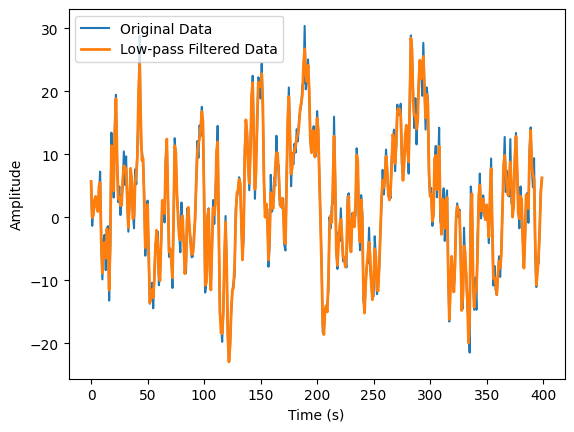

In [6]:
# Define the low-pass filter parameters
cutoff_frequency = 40  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth low-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='low', analog=False, output='ba')

x_train_lpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_lpf[i,0,j,:] = filtered_data

# Plot the original and filtered data
plt.plot(np.arange(x_train_np.shape[3]), x_train_np[0,0,0,:], label='Original Data')
plt.plot(np.arange(x_train_np.shape[3]), x_train_lpf[0,0,0,:], label='Low-pass Filtered Data', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


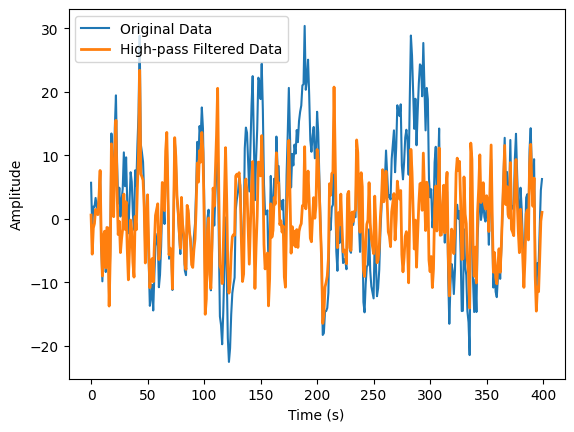

In [7]:
# Define the high-pass filter parameters
cutoff_frequency = 4  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth high-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='high', analog=False, output='ba')

x_train_hpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_hpf[i,0,j,:] = filtered_data

# Plot the original and filtered data
plt.plot(np.arange(x_train_np.shape[3]), x_train_np[0,0,0,:], label='Original Data')
plt.plot(np.arange(x_train_np.shape[3]), x_train_hpf[0,0,0,:], label='High-pass Filtered Data', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


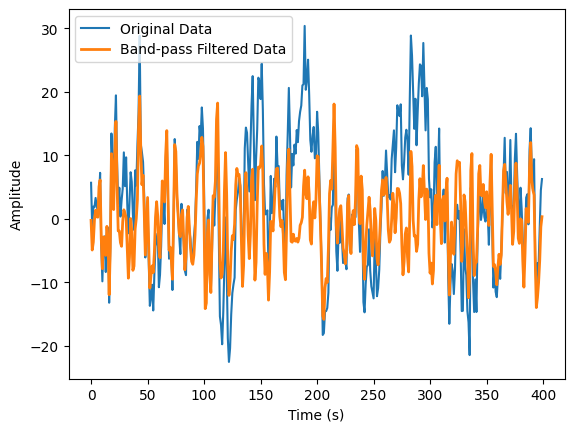

In [8]:
# Define the band-pass filter parameters
cutoff_frequency = np.array([4, 40])  # Cut-off frequency in Hz
sampling_rate = 125  # Sampling rate in Hz (adjust based on your data)

# Design a Butterworth band-pass filter
order = 3  # Filter order
b, a = butter(N=order, Wn=cutoff_frequency / (0.5 * sampling_rate), btype='band', analog=False, output='ba')

x_train_bpf = np.zeros(x_train_np.shape)
# Apply the filter to the data
for i in range(x_train_np.shape[0]):
    for j in range(x_train_np.shape[2]):
        filtered_data = filtfilt(b, a, x_train_np[i,0,j,:])
        x_train_bpf[i,0,j,:] = filtered_data

# Plot the original and filtered data
plt.plot(np.arange(x_train_np.shape[3]), x_train_np[0,0,0,:], label='Original Data')
plt.plot(np.arange(x_train_np.shape[3]), x_train_bpf[0,0,0,:], label='Band-pass Filtered Data', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [9]:
# Convert from numpy back to torch tensor

x_train_lpf = torch.tensor(x_train_lpf).float().to(device)
x_train_hpf = torch.tensor(x_train_hpf).float().to(device)
x_train_bpf = torch.tensor(x_train_bpf).float().to(device)
print(x_train_lpf.shape)
print(x_train_hpf.shape)
print(x_train_bpf.shape)

torch.Size([6768, 1, 22, 400])
torch.Size([6768, 1, 22, 400])
torch.Size([6768, 1, 22, 400])
